Code written by Barbara Morales for the analysis of calculations and simulations of osmotic coefficients using Flat-Bottom Potential method

# Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf

from openmm.unit import bar, mole, litre, kelvin, kilojoule_per_mole, nanometer, angstrom, kilocalorie_per_mole, kilogram, molar, atmosphere, nanosecond, picosecond, femtoseconds
from openmm.unit import Quantity, Unit
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB

from openmm.unit import molar, kilogram, picoseconds
from dataclasses import dataclass

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm
import os
import json
from pathlib import Path

import sys
sys.path.append('..')  # one level up
from salt_data import SaltData, salt_infos


/home/bamo6610/miniconda3/envs/osmotic-analysis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other   

# Inputs

## Defining variables and constants

In [2]:
k : Quantity=4184*(kilojoule_per_mole/nanometer**2)
# k : Quantity=4184*2*(kilojoule_per_mole/nanometer**2)

L_x, L_y, L_z = 4.8, 4.8, 14.4  # lengths in x,y and z caluations
T = 300  # units: K - temperature used for calculations

z_center : Quantity=7.2 * nanometer
delta_z : Quantity=2.4 * nanometer,

NA = 6.02214076E23  # Avogadro's number
R = 8.31446261815324  # units: J/(mol*K) - ideal gas constant

## Specify simulation/experiment details

In [3]:
ion1="Cs" # Use actual name of cation, with capital letters and lower case 
ion2="Br" # Use actual name of anion, with capital letters and lower case 
center_atom1='Cs' # Use actual name of cation, with capital letters and lower case. If polyatomic, specify the ion in the center of the molecule (e.g., for Na use 'Na', for NH4 use 'N') 
center_atom2='Br' # Use actual name of cation, with capital letters and lower case. If polyatomic, specify the ion in the center of the molecule (e.g., for Cl or Cl2 use 'Cl', for NO3 use 'N') 
water='TIP3P' # Specify water model used for labelling purposes and for choosing directory of inputs and outputs 
ff_used = f'Sage 2.1 + {water}' # Specify name of force field used for experiment 
vantHoff=2 # Specify van't Hoff factor of salt (e.g., NaCl uses 2, MgCl2 uses 3)
N_replicates=20 # Specify number of replicates to be analyzed or less if desired
molalities=[0.5] # Specify molalities to be analyzed (can be a list)

## Load salt information

In [4]:
def load_salt_info(ion1, ion2):
    """
    Load all data entries for a specific salt from salt_info and return them as a dictionary
    where the salt appears only once with a subdictionary containing all its data.
    """
    salt = ion1 + ion2
    print(f"Salt to be analyzed: {salt}")

    # Convert dictionaries into SaltData instances
    salt_info_cleaned = [SaltData(**entry) if isinstance(entry, dict) else entry for entry in salt_infos]

    # Filter all entries that match the requested salt and store in a subdictionary
    filtered_entries = {
        f"Molality {entry.molality} mol/kg": {
            "Molarity": entry.molarity,
            "Number of Particles": math.ceil(entry.num_particles),
            "Osmotic Coefficient": entry.osmotic_coefficient,
        }
        for entry in salt_info_cleaned if entry.salt == salt
    }

    # Return results with the salt name as the top-level key
    if filtered_entries:
        return {salt: filtered_entries}
    else:
        return {"Error": f"No data found for {salt}"}


In [5]:
salt_dict=load_salt_info(ion1,ion2)
print(salt_dict)
resname_ions=(ion1+" "+ion2).upper()

wdir = Path(f'FBP_{ion1}{ion2}_{water}')
wdir.mkdir(exist_ok=True)

rdir = Path(f'{wdir}/result_files')
# rdir.mkdir(exist_ok=True)

Salt to be analyzed: CsBr
{'CsBr': {'Molality 0.1 mol/kg': {'Molarity': 0.1, 'Number of Particles': 7, 'Osmotic Coefficient': 0.917}, 'Molality 0.2 mol/kg': {'Molarity': 0.2, 'Number of Particles': 14, 'Osmotic Coefficient': 0.896}, 'Molality 0.3 mol/kg': {'Molarity': 0.3, 'Number of Particles': 20, 'Osmotic Coefficient': 0.882}, 'Molality 0.4 mol/kg': {'Molarity': 0.4, 'Number of Particles': 27, 'Osmotic Coefficient': 0.873}, 'Molality 0.5 mol/kg': {'Molarity': 0.5, 'Number of Particles': 34, 'Osmotic Coefficient': 0.865}, 'Molality 0.6 mol/kg': {'Molarity': 0.601, 'Number of Particles': 40, 'Osmotic Coefficient': 0.861}, 'Molality 0.7 mol/kg': {'Molarity': 0.701, 'Number of Particles': 47, 'Osmotic Coefficient': 0.857}, 'Molality 0.8 mol/kg': {'Molarity': 0.801, 'Number of Particles': 54, 'Osmotic Coefficient': 0.854}, 'Molality 0.9 mol/kg': {'Molarity': 0.901, 'Number of Particles': 60, 'Osmotic Coefficient': 0.852}, 'Molality 1.0 mol/kg': {'Molarity': 1.001, 'Number of Particles': 

# Set-up

## Wall limits set-up

In [6]:
k=k.in_units_of(kilojoule_per_mole/angstrom**2) # notebook works with armstrongs, so change unit of k
Lz=L_z*10
wall1=Lz/3
wall2=wall1+wall1

@dataclass
class Wall:
    '''For representing info about the location and orientation of a wall'''
    wall_pos : Quantity
    wall_normal : Quantity

# define wall positions and ion conc parameters. This can be changed according to simulation set up.
walls = [
    Wall(
        wall_pos   =np.array([0.0, 0.0, wall1]) * angstrom,
        wall_normal=np.array([0.0, 0.0, -1.0]) * angstrom,
    ),
    Wall(
        wall_pos   =np.array([0.0, 0.0, wall2]) * angstrom,
        wall_normal=np.array([0.0, 0.0, 1.0]) * angstrom,
    ),
]

from typing import TypeAlias, TypeVar
Shape : TypeAlias = tuple
N = TypeVar('N')
M = TypeVar('M')

## Functions

In [7]:
def extract_experiment_data(data, salt):
    """
    Extracts molarity values and their corresponding osmotic coefficients
    for a given salt and stores them in two separate lists.
    
    Parameters:
        data (dict): The dictionary containing salt data.
        salt (str): The name of the salt (e.g., "NaCl").

    Returns:
        molarity_list (list): List of molarity values.
        osmotic_coeff_list (list): List of corresponding osmotic coefficients.
    """
    molarity_list = []
    osmotic_coeff_list = []

    if salt in data:
        for molality_key, values in data[f'{salt}'].items():
            molarity_list.append(values["Molarity"])
            osmotic_coeff_list.append(values["Osmotic Coefficient"])
    else:
        print(f"Salt '{salt}' not found in data.")

    return molarity_list, osmotic_coeff_list

In [8]:
def filter_coords_by_wall(
    coords_rel_wall : np.ndarray[Shape[N, M, 3], float], 
    wall_normal : np.ndarray[Shape[3], float],
    dist_unit : Unit=angstrom,
) -> np.ndarray[Shape[N, M, 3], float]:
    '''Zeros out all coordinates which are not in the normal direction relative to a wall'''
    in_right_direction = np.dot(coords_rel_wall, wall_normal) > 0.0
    return np.where(in_right_direction[..., np.newaxis], coords_rel_wall, 0.0) * dist_unit # need to broadcast direction bools, since dot product reduces dimension along xyz

In [9]:
def calculate_force_matrix_all_ions_rel_wall(
    coords : np.ndarray[Shape[N, M, 3], float], 
    wall_pos : np.ndarray[Shape[3], float],
    wall_normal : np.ndarray[Shape[3], float],
    K : Quantity,
    dist_unit : Unit=angstrom,
) -> np.ndarray[Shape[M], float]:
    '''Calculates net harmonic force experience by particle on one side of a wall
    coords should be a 3D array with axes of time, ion index, and spatial coordinate, respectively
    wall_pos is a vector describing the position of the wall in space
    wall_normal gives the normal direction relative to the wall (to determine whether particles behnd or ahead of the wall are kept)'''
    coords_rel_wall = coords - wall_pos
    coords_behind_wall = filter_coords_by_wall(coords_rel_wall, wall_normal=wall_normal, dist_unit=dist_unit)
    z_coords_rel_wall = coords_behind_wall[..., 2]

    # NOTE: cannot use np.abs, as this will discard unit info
    return K * abs(z_coords_rel_wall) # sum along time dimension to leave array with 1 force per particle


In [10]:
def get_universe_area_and_volume(u : mda.Universe) -> tuple[Quantity, Quantity]:
    '''Returns the XY-plane area and box volume of an MDAnalysis universe'''
    box_sizes = u.dimensions[:3] * angstrom
    box_x, box_y, box_z = box_sizes

    A_box = box_x * box_y
    V_box = A_box * box_z

    return A_box, V_box

In [11]:
def replicate_analysis(results, input_name):
    """
    Calculate the mean and uncertainty (standard error) over replicate results 
    for each molal value.
    """
    # Extract values and uncertainties from the results
    op_vals = np.array([r['os_press_mean'].value_in_unit(r['os_press_mean'].unit) for r in results])
    oc_vals = np.array([r['os_coeff_mean'] for r in results])

    # Calculate standard deviations
    std_op = op_vals.std(ddof=1)
    std_oc = oc_vals.std(ddof=1)

    # Calculate means and uncertainties (standard errors)
    mean_op = op_vals.mean()
    op_uncertainty = std_op / np.sqrt(len(op_vals))
    mean_oc = oc_vals.mean()
    oc_uncertainty = std_oc / np.sqrt(len(oc_vals))

    # Display results
    print(f"----- Results standard deviation over replicates for {input_name} molal -----")
    print(f"osmotic pressure: {mean_op:.3f} ± {op_uncertainty:.3f}")
    print(f"osmotic coefficient: {mean_oc:.3f} ± {oc_uncertainty:.3f}")

    # Prepare final results dictionary
    return {
        'mean_osmotic_pressure': mean_op,
        'uncertainty_osmotic_pressure': op_uncertainty,
        'mean_osmotic_coefficient': mean_oc,
        'uncertainty_osmotic_coefficient': oc_uncertainty,
    }

In [12]:
def load_results():
    """
    Load results from json files.
    """
    script_dir = os.getcwd()

    # Initialize lists for OP and OC values and errors
    fbp_op_values, fbp_op_errors, fbp_oc_values, fbp_oc_errors = [], [], [], []

# Loop over molalities and replicate indices
    for mol in molalities:
        if mol % 1 == 0:
            mi1 = f"{mol:.1f}"
            mi = str(int(mol))  # Whole number: strip decimal
        else:
            mi = f"{mol:.1f}".replace('.', '')  # Float: remove the dot
            mi1 = f"{mol:.1f}"  # used in salt_dict key lookup
        # Construct the relative path to the JSON file
        relative_path = os.path.join(script_dir, wdir, f'final_results_{mi}m.json')

        # Open and load the JSON file
        with open(relative_path, 'r') as file:
            results_json = json.load(file)

        # Append values and errors to respective lists
        fbp_op_values.append(results_json['mean_osmotic_pressure'])
        fbp_op_errors.append(results_json['uncertainty_osmotic_pressure'])
        fbp_oc_values.append(results_json['mean_osmotic_coefficient'])
        fbp_oc_errors.append(results_json['uncertainty_osmotic_coefficient'])

    # Create and return the dictionary
    return {
        "OP_Values": fbp_op_values,
        "OP_Errors": fbp_op_errors,
        "OC_Values": fbp_oc_values,
        "OC_Errors": fbp_oc_errors
    }

In [13]:
def osmotic_values(
        mean_force_wall : Quantity, 
        molarity : Quantity,
        cross_sectional_area : Quantity, 
        vant_hoff : int=vantHoff,
        T : Quantity=300*kelvin, 
        printvals : bool=False
    ) -> Quantity:
    '''
    Compute osmotic pressure and coefficient from mean force from wall
    '''
    molarity = molarity.in_units_of(mole / litre)
    R = 0.08314 * bar * litre / (mole * kelvin)  # Ideal gas constant in bar·L/(mol·K)
    osm_press=mean_force_wall/cross_sectional_area
    osm_bar = osm_press.in_units_of(bar / mole)
    osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
    
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    osm_coeff=osm_bar/osm_press_ideal
    
    if printvals:
        print(f"Osmotic Pressure Observed:", osm_bar)
        print(f"Osmotic Pressure Ideal:", osm_press_ideal)
        print(f"Osmotic Coefficient:", osm_coeff)

    return osm_bar, osm_coeff

In [14]:
def osm_experimental(exp_osm_coeff: float, vant_hoff: int = vantHoff, molarity: Quantity = 1*(mole/litre), T = 300*kelvin):
    """
    Compute osmotic coefficients for experimental osmotic pressures
    """
    R = 0.08314 * bar * litre / (mole * kelvin)  # Ideal gas constant in bar·L/(mol·K)
    
    # Convert molarity to compatible units
    molarity = molarity.in_units_of(mole / litre)
    
    # Calculate ideal osmotic pressure
    osm_press_ideal = vant_hoff * molarity * R * T
    
    # Convert osmotic pressure to bar
    osm_press_ideal = osm_press_ideal.in_units_of(bar)
    
    # Apply experimental coefficient
    osm_bar = exp_osm_coeff * osm_press_ideal
    
    # Calculate error
    op_error = (abs(osm_bar - osm_press_ideal) / osm_press_ideal) * 100
    
    # Print values if needed
    # print(f'Ideal Osmotic Pressure: {osm_press_ideal} at concentration {molarity}')
    # print(f'Osmotic Pressure from experimental osmotic coefficient: {osm_bar}')
    
    return osm_bar

In [15]:
def SPW_analysis(
        times : np.ndarray[1, Quantity],
        ion_coords : np.ndarray[Shape[N, M, 3], Quantity],
        molality_info : dict,
        A_box : Quantity,
        walls : list[Wall],
        repnum : int,
        nskip : int=100,
    ) -> None:
    '''Function that calculates osmotic pressure, osmotic coefficient, 
        and performs uncorrelated sample analysis for flat-bottom potential 
        results given as inputs'''

    SPACER = f'\n{"-"*50}\n'

    print(SPACER)
    print(f"CONCENTRATION: {molality_info}")

    # Specifying replicate number
    print("Data for replicate #",repnum)

    ## calculation of mean force matrix
    force_matrices = [
        calculate_force_matrix_all_ions_rel_wall(
            ion_coords,
            wall_pos=wall.wall_pos,
            wall_normal=wall.wall_normal,
            K=k,
            dist_unit=angstrom
        )    
        for wall in walls
     ]

    if force_matrices:
        NULL_FORCE = 0.0 * force_matrices[0].unit # needed to get sum to start with the right units (can't just add to 0)

    force_matrix = sum(force_matrices, start=NULL_FORCE) / len(force_matrices) # NOTE: need to average over all walls, and numpy can't get the job done on its own
    forces_time_avg = force_matrix.mean(axis=0)
    forces_over_all_ions = force_matrix.sum(axis=1)

    ## calculation of autocorrelation function and plot of uncorrelated samples
    # statistical values of t0 (time after equil), g (statistical efficiency/correlation time of equil data), Neff (# of eff samples)
    t0, g, Neff_max = timeseries.detect_equilibration(forces_over_all_ions._value, nskip=nskip) # compute indices of uncorrelated timeseries
    forces_over_all_ions_equil = forces_over_all_ions[t0:]
    uncorr_sample_idxs = timeseries.subsample_correlated_data(forces_over_all_ions_equil, g=g)
    uncorr_sample_idxs = np.array(uncorr_sample_idxs)
    
    sample_forces = forces_over_all_ions_equil[uncorr_sample_idxs]
    sample_times  = times[uncorr_sample_idxs]

    # mean of full time series
    force_mean = sample_forces.mean()
    force_std  = sample_forces.std() / np.sqrt(Neff_max - 1) # TODO: make sure propagation of errors is being done correctly (since now the addition is being done up-front)

    ## calculation of osmotic values from statistical mean and std error
    print(f"RESULTS:")
    osm_press_mean, osm_coeff_mean = osmotic_values(force_mean, molarity=molality_info['Molarity'], cross_sectional_area=A_box) 
    osm_press_std , osm_coeff_std  = osmotic_values(force_std , molarity=molality_info['Molarity'], cross_sectional_area=A_box)

    print(f"Osmotic Pressure = {osm_press_mean}+/-{osm_press_std**2}")
    print(f"\nOsmotic Coefficient = {osm_coeff_mean}+/-{osm_coeff_std**2}")
    print(SPACER)
    
    ################################################################################################
    # Create dictionary with results
    results = dict()
    
    results['os_press_mean'] = osm_press_mean
    results['os_press_var'] = osm_press_std**2
    results['os_coeff_mean'] = osm_coeff_mean
    results['os_coeff_var'] = osm_coeff_std**2
    
    return results


In [16]:
def run_analysis(u, atom_group, saltdict, repnum):
    """Run SPW_analysis using ion molarity (Quantity mol/L) instead of number density."""
    m_info = dict(saltdict)  

    # --- coordinates (with units) ---
    times = np.array([u.trajectory.time for _ in u.trajectory]) * picosecond
    all_coords = u.trajectory.coordinate_array * angstrom
    ion_coords = all_coords[:, atom_group.indices, :]

    # --- geometry/volume between walls ---
    A_box, V_box = get_universe_area_and_volume(u)     # areas/volumes with units
    wall_sep = abs((walls[1].wall_pos - walls[0].wall_pos)[2])  # length with units
    V_mem = A_box * wall_sep                           # volume with units

    # --- molarity (Quantity, mol/L) ---
    n_mol = m_info['Number of Particles'] / AVOGADRO_CONSTANT_NA    # -> Quantity [mole]
    molarity_q = (n_mol / V_mem).in_units_of(mole / litre)          # -> Quantity [mol/L]

    # Store exactly what downstream expects
    m_info['Molarity'] = molarity_q              # Quantity, used by osmotic_values(...)
    # Optional extras if you want them
    m_info['Concentration (M)'] = molarity_q.value_in_unit(mole / litre)  # float for plotting
    m_info['Quantity Type'] = 'molarity'

    # --- analysis ---
    results = SPW_analysis(times, ion_coords, m_info, A_box, walls, N_replicates)
    return results


In [17]:
def get_ion_array(u,ions):
    '''
    Function to get array of ion's z coordinate positions throughout trajectory of all samples.
    '''
    ion_array=[]
    for ts in u.trajectory:
        ions_z = ions.positions[:,2]
        ion_array.append(ions_z)
    ionz=np.array(ion_array)/10
    zvals=ionz.flatten()
    return zvals

In [18]:
def mol_keys(mol):
    """Return (mi, mi1) string keys for your dicts, given a float molality."""
    if mol % 1 == 0:
        return str(int(mol)), f"{mol:.1f}"         # ('1', '1.0')
    return f"{mol:.1f}".replace('.', ''), f"{mol:.1f}"  # ('05', '0.5')

def to_float_M(x):
    """Return molarity as float (mol/L), whether x is a Quantity or float."""
    try:
        return x.value_in_unit(mole / litre)
    except AttributeError:
        return float(x)


def rebin_piecewise_constant(edges_src, y_src, edges_dst):
    """
    Rebin y(z) that is piecewise-constant on edges_src to edges_dst, conserving totals.
    y_src can be 'ions/bin' or 'mol/L' — both treated as constant across each src bin.
    """
    widths_src = np.diff(edges_src)
    lam = np.zeros_like(y_src, dtype=float)           # 'per nm' when integrating along z
    valid = widths_src > 0
    lam[valid] = y_src[valid] / widths_src[valid]

    out = np.zeros(len(edges_dst) - 1, dtype=float)
    i = j = 0
    while i < len(y_src) and j < len(out):
        a, b = edges_src[i], edges_src[i+1]
        A, B = edges_dst[j],  edges_dst[j+1]
        left, right = max(a, A), min(b, B)
        overlap = right - left
        if overlap > 0:
            out[j] += lam[i] * overlap
        if b <= B:
            i += 1
        else:
            j += 1
    return out


def count_profile_fixed_Lz(u, ag, dz_nm=0.05):
    """
    Time-averaged *counts/bin* along z using a fixed Lz from the first frame.
    Returns: (edges, centers, counts_avg)
    """
    Lz_nm = u.trajectory.ts.dimensions[2] / 10.0
    edges = np.arange(-Lz_nm/2, Lz_nm/2 + dz_nm, dz_nm)
    centers = 0.5 * (edges[:-1] + edges[1:])

    acc = np.zeros_like(centers, dtype=float)
    n = 0
    for ts in u.trajectory:
        mid = Lz_nm / 2.0
        z_nm = ag.positions[:, 2] / 10.0 - mid
        counts, _ = np.histogram(z_nm, bins=edges)
        acc += counts
        n += 1
    return edges, centers, acc / max(n, 1)

def molarity_profile_variable_Lz(u, ag, dz_nm=0.05):
    """
    Time-averaged molarity profile c(z) in mol/L, allowing Lz to vary per frame.
    Returns: (edges_universe, centers_universe, c_mean_universe)
    """
    # Build a per-universe global grid from the maximum frame Lz
    Lz_max_nm = max(ts.dimensions[2] for ts in u.trajectory) / 10.0
    zmax = Lz_max_nm / 2.0
    edges_g = np.arange(-zmax, zmax + dz_nm, dz_nm)
    centers_g = 0.5*(edges_g[:-1] + edges_g[1:])
    n_g = len(centers_g)

    amount_sum = np.zeros(n_g)  # (mol/L) * nm
    cover_len  = np.zeros(n_g)  # nm

    for ts in u.trajectory:
        Lx_nm, Ly_nm, Lz_nm = ts.dimensions[:3] / 10.0
        mid = Lz_nm / 2.0

        edges_f  = np.arange(-Lz_nm/2.0, Lz_nm/2.0 + dz_nm, dz_nm)
        widths_f = np.diff(edges_f)

        z_nm = ag.positions[:, 2] / 10.0 - mid
        counts, _ = np.histogram(z_nm, bins=edges_f)

        # mol/L in each frame bin
        bin_vol_L = (Lx_nm * Ly_nm) * widths_f * 1e-24  # nm^3 -> L
        with np.errstate(divide='ignore', invalid='ignore'):
            c_frame = (counts / NA) / bin_vol_L  # mol/L

        # conservative rebin to edges_g
        i = j = 0
        while i < len(c_frame) and j < n_g:
            a, b = edges_f[i], edges_f[i+1]
            A, B = edges_g[j], edges_g[j+1]
            left, right = max(a, A), min(b, B)
            overlap = right - left
            if overlap > 0:
                amount_sum[j] += c_frame[i] * overlap
                cover_len[j]  += overlap
            if b <= B:
                i += 1
            else:
                j += 1

    c_mean = np.zeros_like(centers_g)
    m = cover_len > 0
    c_mean[m] = amount_sum[m] / cover_len[m]
    return edges_g, centers_g, c_mean


def build_stacks(us, molalities, select_expr, per_universe_fn, dz_nm=0.05):
    """
    Build stacks (replicates x bins) for a given species/metric across all molalities.
    per_universe_fn must return (edges_u, centers_u, y_u).
    Returns: centers_global, stack
    """
    raw = []
    Lz_max = 0.0

    for mol in molalities:
        mi, mi1 = mol_keys(mol)
        for u in us[mi]:
            ag = u.select_atoms(select_expr)
            edges_u, centers_u, y_u = per_universe_fn(u, ag, dz_nm)
            raw.append((edges_u, y_u))
            Lz_max = max(Lz_max, edges_u[-1] - edges_u[0])

    # global edges across all replicates of this species
    zmax = Lz_max / 2.0
    edges_g = np.arange(-zmax, zmax + dz_nm, dz_nm)
    centers_g = 0.5*(edges_g[:-1] + edges_g[1:])

    # rebin everyone to global edges
    stack = np.vstack([rebin_piecewise_constant(eu, yu, edges_g) for eu, yu in raw])
    return centers_g, stack

# ---------- plotting ----------
def plot_stack_and_mean(
    x, stack, color, label, ylabel,
    molar_line=None, title=None, faint=0.15,
    output_path=None, dpi=300
):
    fig, ax = plt.subplots(figsize=(9.5, 6))

    # replicates
    for y in stack:
        ax.plot(x, y, alpha=faint, color=color)

    # mean
    ax.plot(x, stack.mean(axis=0), lw=2.6, color=color, label=f"{label} (mean)")

    # ref line
    if molar_line is not None:
        ax.axhline(y=molar_line, color='k', lw=2)

    ax.set_xlabel("z (nm)")
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    ax.grid(True)  
    ax.legend()
    fig.tight_layout()

    # save 
    if output_path is not None:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        fig.savefig(output_path, dpi=dpi, bbox_inches="tight")

    plt.show()


def plot_three_together(
    x, stacks, colors, labels, ylabel,
    molar_line=None, title=None, faint=0.12,
    output_path=None, dpi=300
):
    fig, ax = plt.subplots(figsize=(10, 6))

    # replicates
    for stack, c in zip(stacks, colors):
        for y in stack:
            ax.plot(x, y, alpha=faint, color=c)

    # means
    for stack, c, lab in zip(stacks, colors, labels):
        ax.plot(x, stack.mean(axis=0), lw=2.6, color=c, label=f"{lab} (mean)")

    if molar_line is not None:
        ax.axhline(y=molar_line, color='k', lw=2)

    ax.set_xlabel("z (nm)")
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    ax.grid(True) 
    ax.legend()
    fig.tight_layout()

    if output_path is not None:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        fig.savefig(output_path, dpi=dpi, bbox_inches="tight")

    plt.show()

In [19]:
def serialize(obj):
    if isinstance(obj, dict):
        return {k: serialize(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [serialize(item) for item in obj]
    elif isinstance(obj, Quantity):
        return {"value": round(obj.value_in_unit(obj.unit), 4), "unit": str(obj.unit)}
    elif isinstance(obj, float):
        return round(obj, 4)
    else:
        return obj

In [20]:
def format_dict(dictionary):
    '''Function that formats the decimals of the values in dictionary'''
    newdict = {}
    for x in dictionary:
        if isinstance(dictionary[x],float):
            newdict[x] = round(dictionary[x],3)
        else:
            newdict[x] = dictionary[x]
    return newdict

## Load data

### Experimental data

In [21]:
# Experimental values of osmotic coefficient obtained from Hamer & Wu paper
exp_concs, yexpOC = extract_experiment_data(salt_dict,f"{ion1}{ion2}")

# Convert quantities to scalars in appropriate units for plotting
exp_concs_values = [x*(molar) for x in exp_concs]

# Experimental values of osmotic pressure obtained from Hamer & Wu paper
yexpOP=[]
for i,m in enumerate(exp_concs):
    op_res=osm_experimental(exp_osm_coeff=yexpOC[i], vant_hoff=vantHoff, molarity=exp_concs_values[i])
    yexpOP.append(op_res.value_in_unit(op_res.unit))

### Simulation data

In [22]:
us = {}
ions = {}

# Load trajectories and ion selections
for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}" # '1' or '0.5'
        mi = str(int(mol))
    else:
        mi = f"{mol:.1f}".replace('.', '') # '0.5' → '05'
        mi1 = f"{mol:.1f}"

    us[mi] = []
    ions[mi] = []


    for i in range(N_replicates):
        postfix = f'{mi}m_r{i}'
        frdir = f'{rdir}_{mi}m'
        pdb_path = os.path.join(frdir, f'md{postfix}.pdb')
        xtc_path = os.path.join(frdir, f'md{postfix}.xtc')
        cache_file = os.path.join(frdir, f'md{postfix}_ioncache.npz')

        if os.path.exists(cache_file):
            print(f'Loading cache from {cache_file}')
            data = np.load(cache_file, allow_pickle=True)
            required_keys = {'ion_indices', 'ion1_indices', 'ion2_indices', 'pdb', 'xtc'}

            if all(key in data for key in required_keys):
                u = mda.Universe(data['pdb'].item(), data['xtc'].item())
                u.transfer_to_memory()
                us[mi].append(u)

                ions[mi].append(u.atoms[data['ion_indices']])

                continue  # Skip to next replicate if cache was valid
            else:
                print(f"⚠️ Cache missing required keys. Rebuilding cache for {postfix}.")

        # No valid cache, process trajectory from scratch
        print(f'Processing trajectory for {postfix}')
        u = mda.Universe(pdb_path, xtc_path)
        u.transfer_to_memory()
        us[mi].append(u)

        # Select ions
        if center_atom1 != center_atom2:
            ion_group = u.select_atoms(f'element {center_atom1}', f'element {center_atom2}')
        else:
            ion_group = u.select_atoms(f'element {center_atom1}')


        ions[mi].append(ion_group)


        # Save updated cache
        np.savez(
            cache_file,
            pdb=pdb_path,
            xtc=xtc_path,
            ion_indices=ion_group.indices
        )
        print(f'Saved ion cache to {cache_file}')


Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r0_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r1_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r2_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r3_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r4_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r5_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r6_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r7_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r8_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r9_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r10_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r11_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_05m/md05m_r12_ioncache.npz
Loading cache from FBP_CsBr_TIP3P/result_files_0

# Analysis

## Concentration Profiles

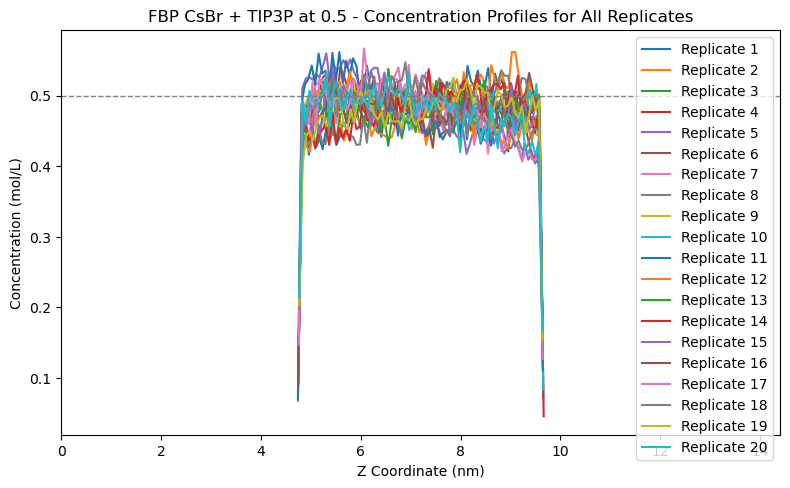

In [23]:
zvals = []
concentration_profiles = []
z = []

for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"       # '1.0'
        mi = str(int(mol))       # '1'
    else:
        mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
        mi1 = f"{mol:.1f}"       # '0.5'

    frdir = f'{rdir}_{mi}m'
    N_i = salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg']['Number of Particles']

    plt.figure(figsize=(8, 5)) 

    for i in range(N_replicates):
        ui = us[mi][i]  # Universe for replicate i
        ionsi = ions[mi][i]  # Selected ions for replicate i

        zvals_i = get_ion_array(ui, ionsi)
        zvals.append(zvals_i)

        # Calculate histogram
        concs, bins = np.histogram(
            zvals_i,
            bins=int(Lz/2),
            weights=np.full_like(zvals_i, N_i / zvals_i.size)
        )
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        plt.plot(bin_centers, concs, label=f'Replicate {i+1}')  # Different color line per replicate
        concentration_profiles.append(concs)
        z.append(bin_centers)

    # Add horizontal line at bulk concentration
    plt.axhline(y=mol, color='grey', linestyle='--', linewidth=1)

    # Customize and save plot
    plt.title(f'FBP {ion1}{ion2} + {water} at {mi1} - Concentration Profiles for All Replicates')
    plt.xlabel('Z Coordinate (nm)')
    plt.ylabel('Concentration (mol/L)')
    plt.xlim(0, 14.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{frdir}/conc_prof_allreps_{mi}m_{ion1}{ion2}.png')
    plt.show()


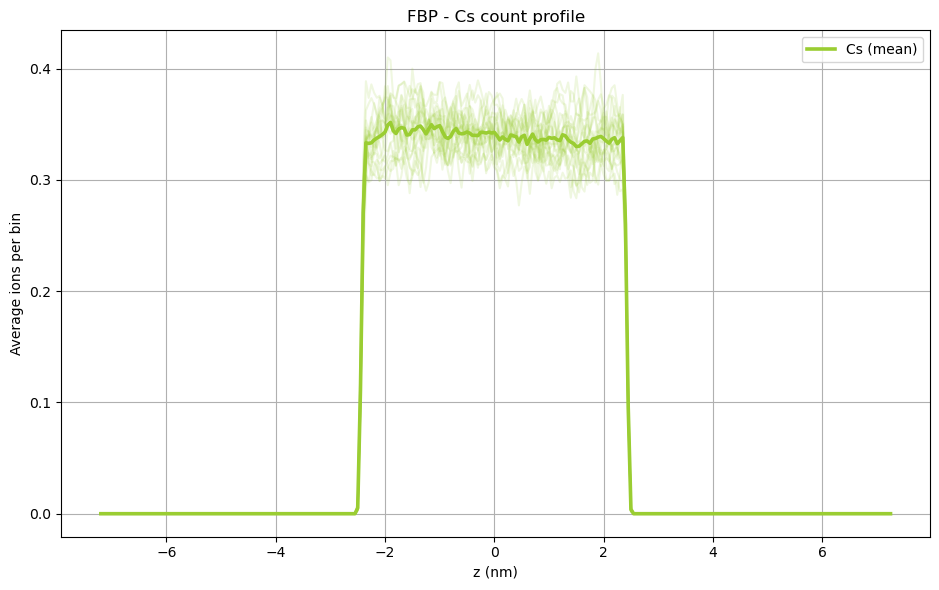

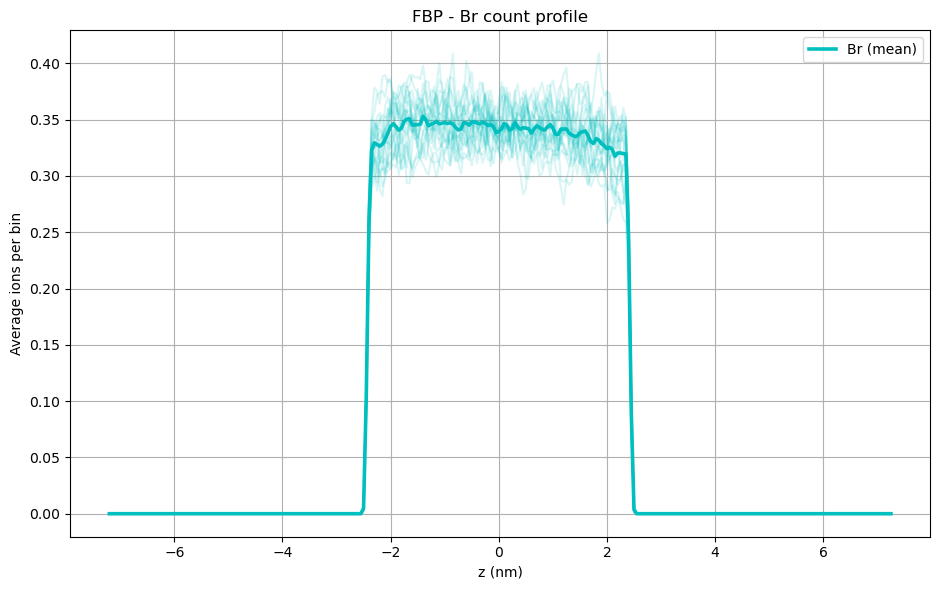

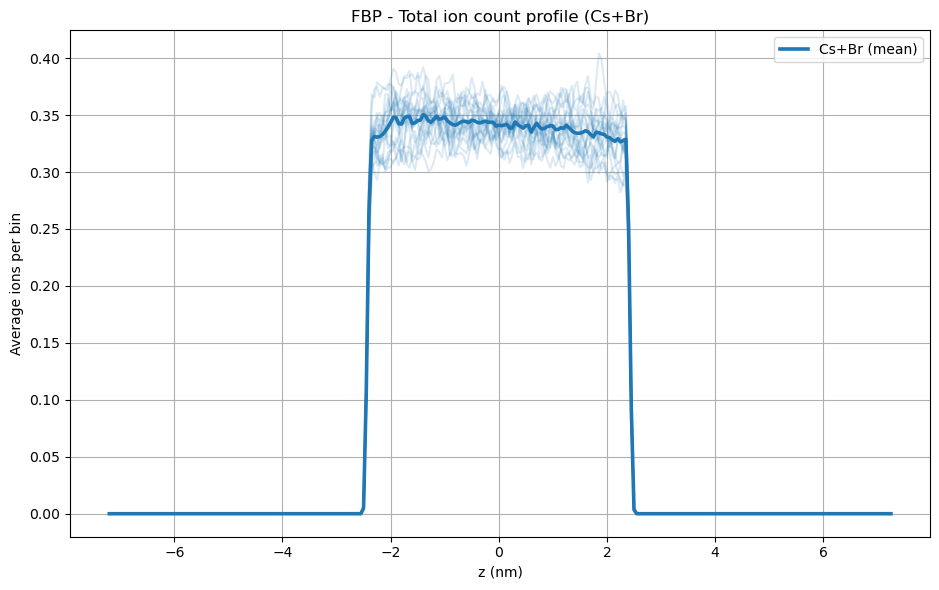

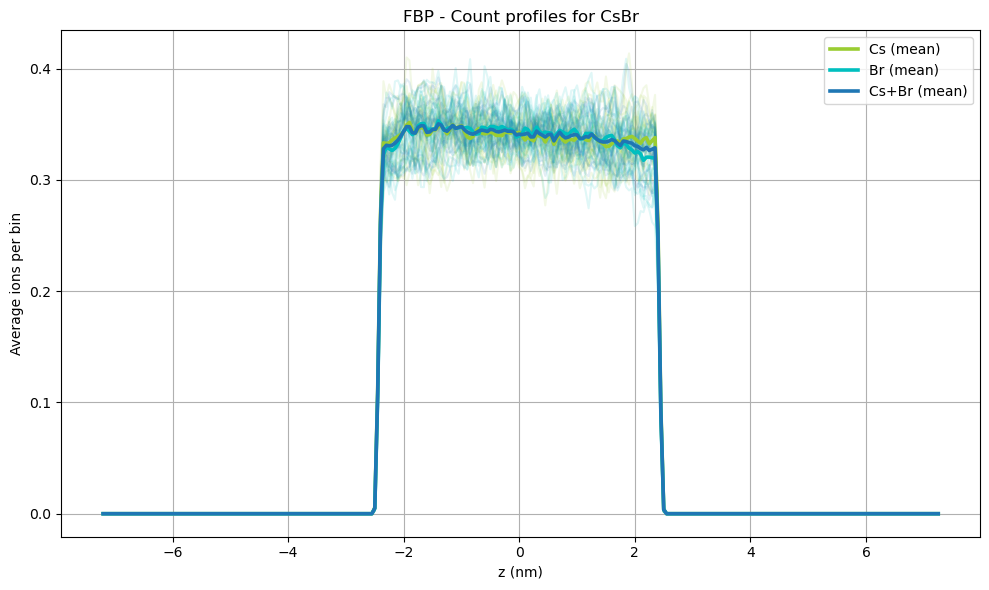

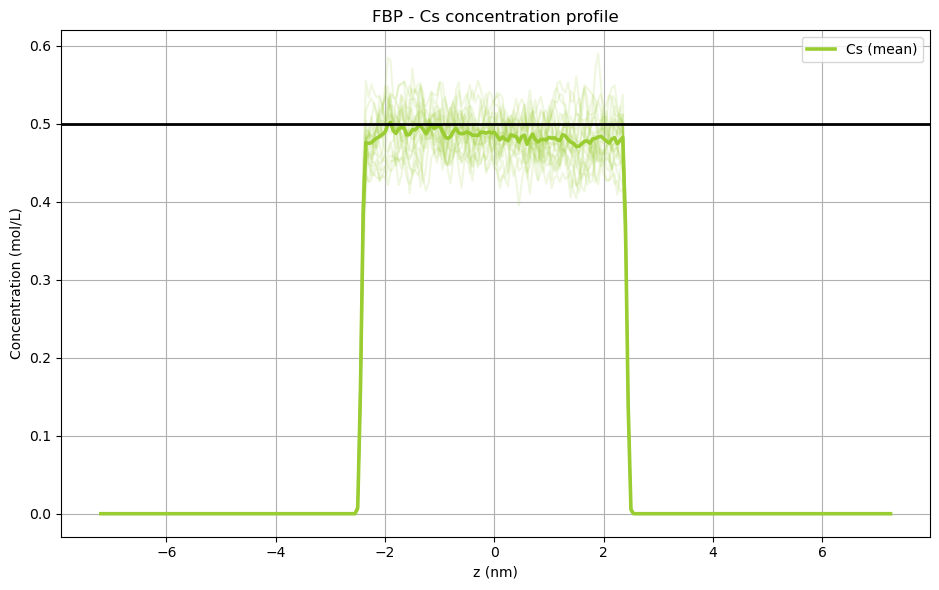

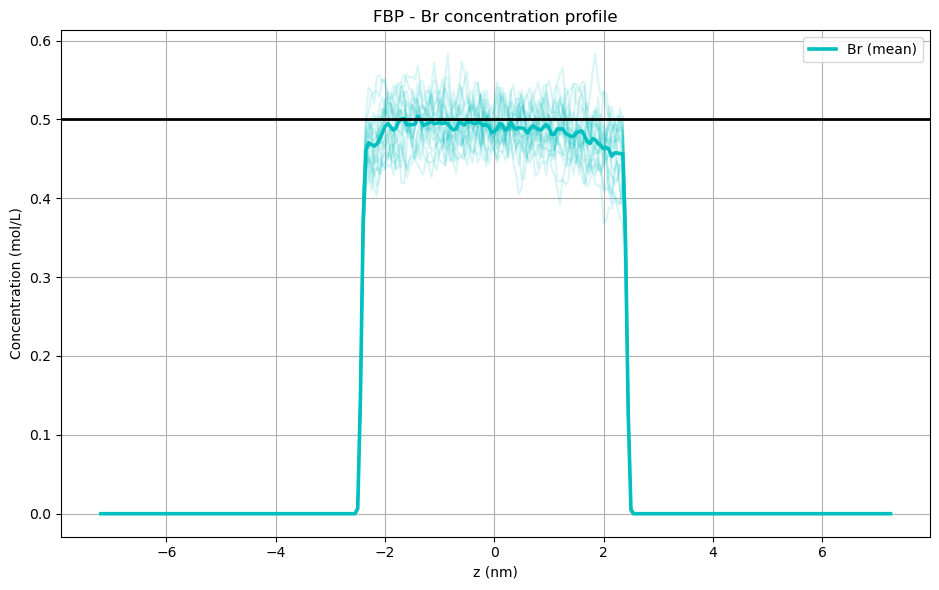

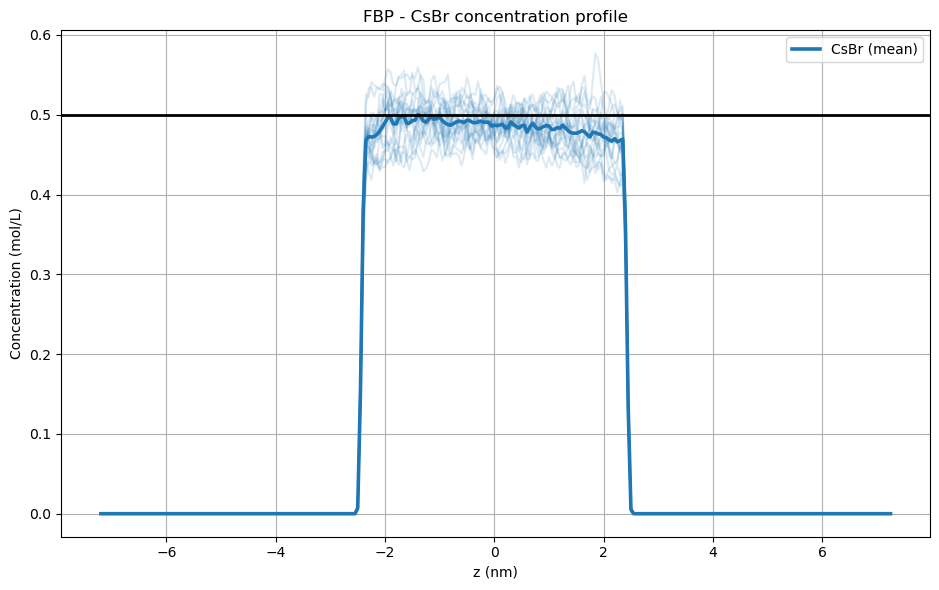

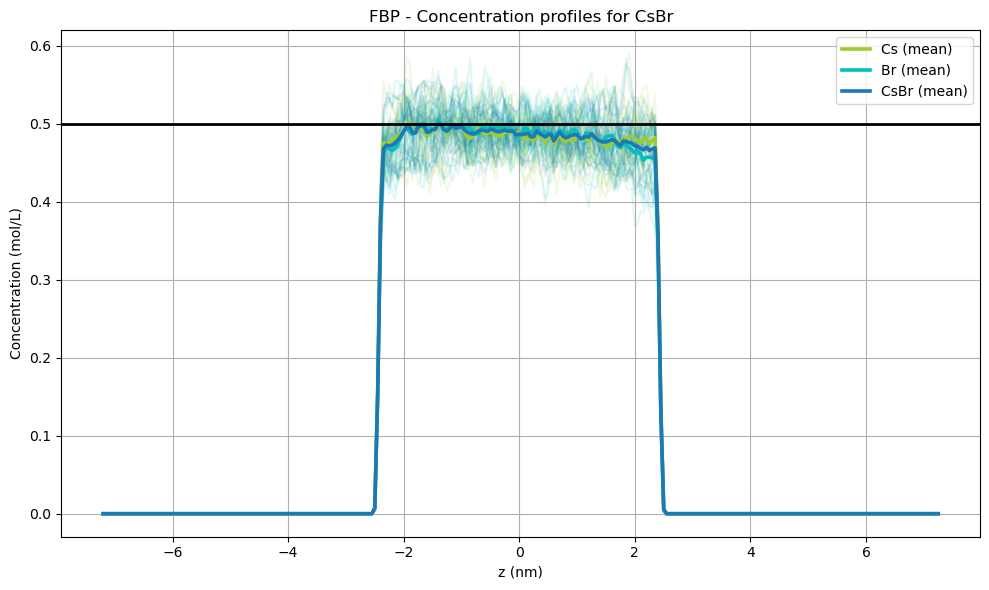

In [24]:
# --- bin width ---
dz_nm = 0.05

# --- colors ---
c1_col = 'yellowgreen'   # ion1
c2_col = 'c'             # ion2
salt_col = 'tab:blue'    # salt

# --- build stacks: COUNTS (ions/bin) ---
cent_counts_1, counts_stack_1 = build_stacks(
    us, molalities, select_expr=f'element {center_atom1}',
    per_universe_fn=count_profile_fixed_Lz, dz_nm=dz_nm
)
cent_counts_2, counts_stack_2 = build_stacks(
    us, molalities, select_expr=f'element {center_atom2}',
    per_universe_fn=count_profile_fixed_Lz, dz_nm=dz_nm
)
# counts_stack_tot = counts_stack_1 + counts_stack_2
counts_stack_salt = 0.5 * (counts_stack_1 + counts_stack_2)

# --- build stacks: MOLARITY (mol/L) ---
cent_M_1, M_stack_1 = build_stacks(
    us, molalities, select_expr=f'element {center_atom1}',
    per_universe_fn=molarity_profile_variable_Lz, dz_nm=dz_nm
)
cent_M_2, M_stack_2 = build_stacks(
    us, molalities, select_expr=f'element {center_atom2}',
    per_universe_fn=molarity_profile_variable_Lz, dz_nm=dz_nm
)
M_stack_salt = 0.5 * (M_stack_1 + M_stack_2)

# --- horizontal reference line (molarity) ---
_, mi1_last = mol_keys(molalities[-1])
molar_line = to_float_M(salt_dict[f'{ion1}{ion2}'][f'Molality {mi1_last} mol/kg']['Molarity'])

# === PLOTS: COUNTS ===
plot_stack_and_mean(
    cent_counts_1, counts_stack_1, c1_col, ion1,
    ylabel="Average ions per bin", 
    # molar_line=molar_line,
    title=f"FBP - {ion1} count profile",
    output_path=f'{frdir}/countsprof_{mi}m_{ion1}.png'
)
plot_stack_and_mean(
    cent_counts_2, counts_stack_2, c2_col, ion2,
    ylabel="Average ions per bin",  
    # molar_line=molar_line,
    title=f"FBP - {ion2} count profile",
    output_path=f'{frdir}/countsprof_{mi}m_{ion2}.png'
)
plot_stack_and_mean(
    cent_counts_1, counts_stack_salt, salt_col, f"{ion1}+{ion2}",
    # cent_counts_1, counts_stack_tot, salt_col, f"{ion1}+{ion2}",
    ylabel="Average ions per bin",  
    # molar_line=molar_line,
    title=f"FBP - Total ion count profile ({ion1}+{ion2})",
    output_path=f'{frdir}/countsprof_{mi}m_{ion1}{ion2}.png'
)
plot_three_together(
    cent_counts_1, [counts_stack_1, counts_stack_2, counts_stack_salt],
    # cent_counts_1, [counts_stack_1, counts_stack_2, counts_stack_tot],
    [c1_col, c2_col, salt_col], [ion1, ion2, f"{ion1}+{ion2}"],
    ylabel="Average ions per bin",  
    # molar_line=molar_line,
    title=f"FBP - Count profiles for {ion1}{ion2}",
    output_path=f'{frdir}/countsprof_{mi}m_ALL.png'
)

# === PLOTS: MOLARITY ===
plot_stack_and_mean(
    cent_M_1, M_stack_1, c1_col, ion1,
    ylabel="Concentration (mol/L)", 
    molar_line=molar_line,
    title=f"FBP - {ion1} concentration profile",
    output_path=f'{frdir}/concprof_{mi}m_{ion1}.png'
)
plot_stack_and_mean(
    cent_M_2, M_stack_2, c2_col, ion2,
    ylabel="Concentration (mol/L)", 
    molar_line=molar_line,
    title=f"FBP - {ion2} concentration profile",
    output_path=f'{frdir}/concprof_{mi}m_{ion2}.png'
)
plot_stack_and_mean(
    cent_M_1, M_stack_salt, salt_col, f"{ion1}{ion2}",
    ylabel="Concentration (mol/L)", 
    molar_line=molar_line,
    title=f"FBP - {ion1}{ion2} concentration profile",
    output_path=f'{frdir}/concprof_{mi}m_{ion1}{ion2}.png'
)
plot_three_together(
    cent_M_1, [M_stack_1, M_stack_2, M_stack_salt],
    [c1_col, c2_col, salt_col], [ion1, ion2, f"{ion1}{ion2}"],
    ylabel="Concentration (mol/L)", 
    molar_line=molar_line,
    title=f"FBP - Concentration profiles for {ion1}{ion2}",
    output_path=f'{frdir}/concprof_{mi}m_ALL.png'
)


## Calculate results

In [25]:
# Initialize a dictionary to store results for each concentration
results = {}

# Loop over concentrations
for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"       # '1.0'
        mi = str(int(mol))       # '1'
    else:
        mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05', '2.3' → '23'
        mi1 = f"{mol:.1f}"       # '0.5', '2.3'

    concentration = f"{mi}m"     # ➜ matches how you load data (e.g., '05m')
    key = f"{mi}"                # ➜ matches how you stored keys in us/ions

    results[concentration] = []

    for i, (ui, ionsi) in enumerate(zip(us[key], ions[key])):
        print(i)
        results[concentration].append(
            run_analysis(ui, ionsi, salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg'], i)
        )


0

--------------------------------------------------

CONCENTRATION: {'Molarity': 0.5071098493950683 mol/L, 'Number of Particles': 34, 'Osmotic Coefficient': 0.865, 'Concentration (M)': np.float64(0.5071098493950683), 'Quantity Type': 'molarity'}
Data for replicate # 20
RESULTS:
Osmotic Pressure = 24.955076463856507 bar+/-3.265599507439564 bar**2

Osmotic Coefficient = 0.9864965904975908+/-0.005103125973170402

--------------------------------------------------

1

--------------------------------------------------

CONCENTRATION: {'Molarity': 0.5059834783081559 mol/L, 'Number of Particles': 34, 'Osmotic Coefficient': 0.865, 'Concentration (M)': np.float64(0.5059834783081559), 'Quantity Type': 'molarity'}
Data for replicate # 20
RESULTS:
Osmotic Pressure = 21.987954054308755 bar+/-1.0459564428918458 bar**2

Osmotic Coefficient = 0.8711385124500876+/-0.0016417929479904862

--------------------------------------------------

2

--------------------------------------------------

CONCENT

In [26]:
replicate_results = {}

for mol in molalities:
    # Format molality
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"       # '1.0'
        mi = str(int(mol))       # '1'
    else:
        mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
        mi1 = f"{mol:.1f}"       # '0.5'

    keymi=f'{mi}m'
    replicate_results[f'{keymi}'] = replicate_analysis(results[keymi], mi1)


----- Results standard deviation over replicates for 0.5 molal -----
osmotic pressure: 23.692 ± 0.295
osmotic coefficient: 0.939 ± 0.012


In [27]:
# Loop through replicate_results and write to JSON files
for concentration, data in results.items():
    filename = f"{rdir}_{concentration}/results_{concentration}.json"
    with open(filename, "w") as outfile:
        json.dump(serialize(data), outfile, indent=4)

for concentration, data in replicate_results.items():
    filename = f"{wdir}/final_results_{concentration}.json" 
    with open(filename, "w") as outfile:
        json.dump(format_dict(data), outfile, indent=4)

## Plotting Results

In [28]:
# Formatting font size
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

In [29]:
fbp_results=load_results()

In [30]:
molalities

[0.5]

### Plot osmotic coefficients

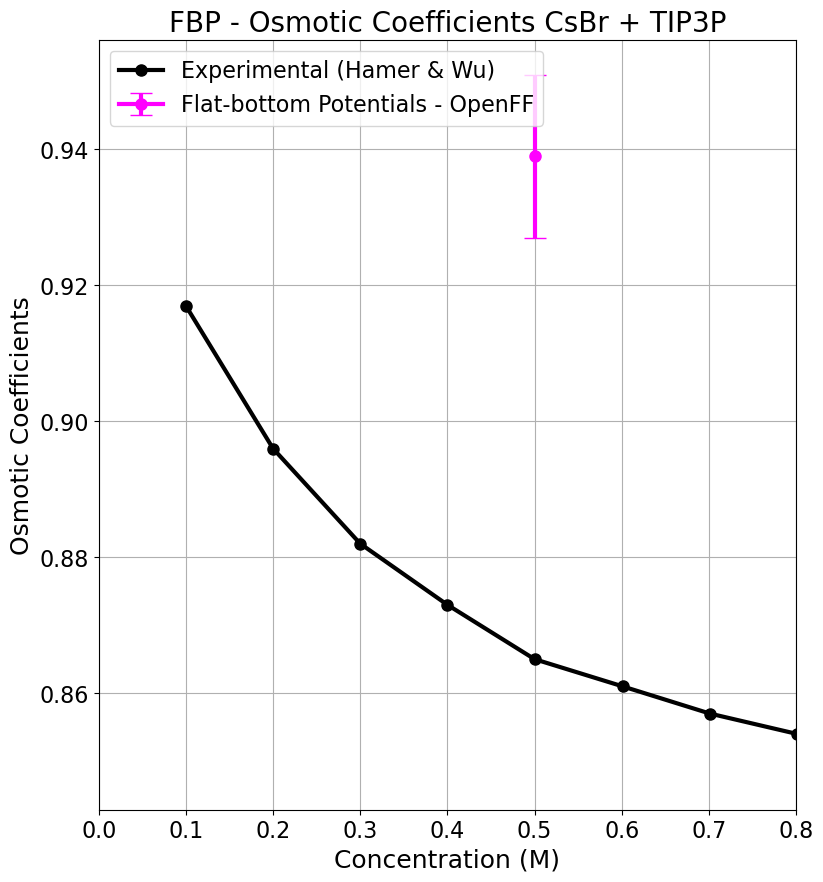

In [31]:
# Osmotic coefficient plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))

# Experimental data
plt.plot(exp_concs, yexpOC, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)

# Flat-bottom Potentials data with error bars
plt.errorbar(molalities, fbp_results['OC_Values'], yerr=fbp_results['OC_Errors'], 
             fmt='o', linestyle='-', color='magenta', capsize=8, 
             label='Flat-bottom Potentials - OpenFF', linewidth=3, markersize=8)

plt.xlim(0,molalities[-1]+0.3)
plt.xlabel("Concentration (M)",fontsize=MEDIUM_SIZE)
plt.ylabel("Osmotic Coefficients",fontsize=MEDIUM_SIZE)
plt.title(f'FBP - Osmotic Coefficients {ion1}{ion2} + {water}', fontsize=BIGGER_SIZE)
plt.legend(prop={'size': 16}, loc='upper left')
plt.grid()
plt.savefig(f'{wdir}/ocs.png')
plt.show()

### Plot osmotic pressure

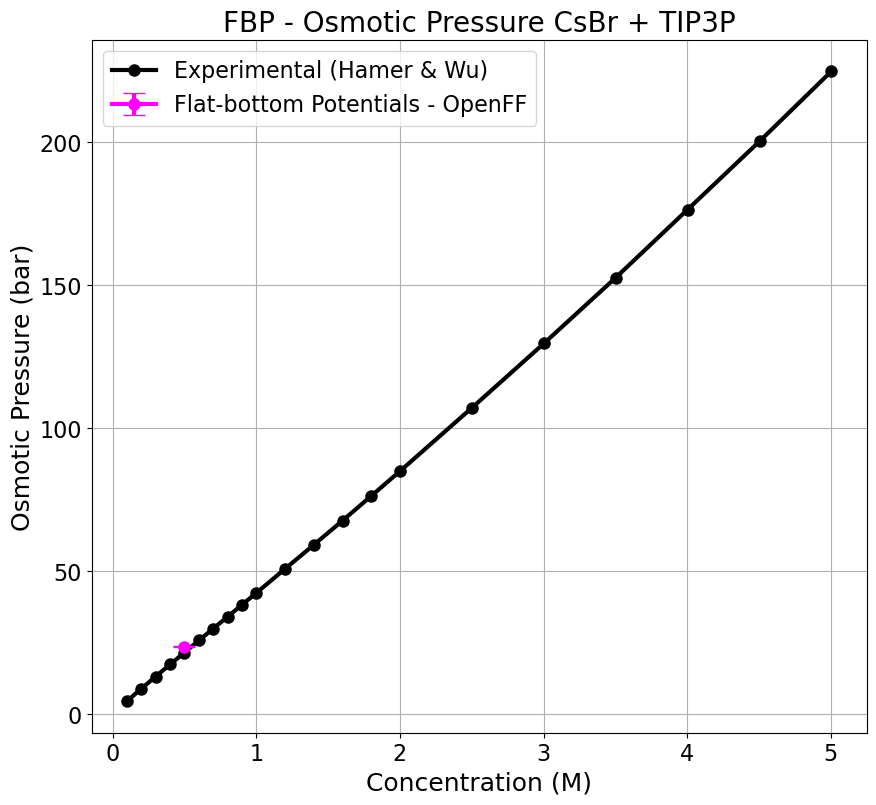

In [32]:
## Osmotic pressure plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,9))

# Experimental data
plt.plot(exp_concs, yexpOP, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)

# Flat-bottom Potentials data with error bars
plt.errorbar(molalities, fbp_results['OP_Values'], yerr=fbp_results['OP_Errors'], 
             fmt='o', linestyle='-', color='magenta', capsize=8, 
             label='Flat-bottom Potentials - OpenFF', linewidth=3, markersize=8)

plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel("Osmotic Pressure (bar)",fontsize=MEDIUM_SIZE)
plt.title(f'FBP - Osmotic Pressure {ion1}{ion2} + {water}', fontsize=BIGGER_SIZE)
plt.legend()
plt.grid()
plt.savefig(f'{wdir}/ops.png')
plt.show()